In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [2]:
class DogsVSCats():
    IM_SIZE = 50
    # dataset path
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS:0,DOGS:1}
    training_data = []
    cat_count = 0
    dog_count = 0
    damaged_images = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            for f in tqdm(os.listdir(label)):
                try:
                    # gray scale and resize images
                    path = os.path.join(label,f)
                    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img,(self.IM_SIZE,self.IM_SIZE))
                    '''
                    label images with one-hot vector, like [0, 1] or [1, 0]
                    training_data: [[image data, one hot vector],......]
                    '''
                    self.training_data.append([np.array(img),np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.cat_count += 1

                    elif label == self.DOGS:
                        self.dog_count += 1
                except Exception as e:
                    self.damaged_images += 1
                    print("{} destroyed.".format(path))
                    continue
                    
        #save data in npy file, not reload data again in the future
        np.random.shuffle(self.training_data)
        np.save("training_data.npy",self.training_data)
        #print all results
        print(f"cat has {self.cat_count} images.")
        print(f"dog has {self.dog_count} images.")
        print(f"{self.damaged_images} images destroyed")


In [3]:
#pickle is a more efficient way to process data, cos it's in binary
training_data = np.load("training_data.npy",allow_pickle=True)

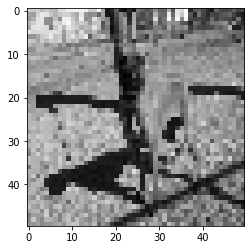

[0. 1.]


In [4]:
# test training_data
import matplotlib.pyplot as plt
#matplot deflaut image shows not in gray even you the images data is in gray scale
plt.imshow(training_data[0][0],cmap ="gray")
plt.show()
print(training_data[0][1])

In [46]:
import torch.nn as nn
import torch 
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from make_training_data import DogsVSCats
#build neural network
# all test and train images is 50*50 pixel

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32,64,5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 conv
        self.conv3 = nn.Conv2d(64,128,5)
        
        # here we implement get_dimension() to get dimension of linear function
   
        # 2 linear layers, shrinking dimensions of output, final output is 2-dimensions for classification
        self.fc1 = nn.Linear(128*2*2, 512) #flattening.
        self.fc2 = nn.Linear(512, 2) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).


    def forward(self, x):
    	# three convoluitonal layers
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        # two fully connection layers
        x = x.view(-1, 128*2*2)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)

In [35]:
# only for calculating linear dimension
x = torch.randn(50,50).view(-1,1,50,50)
layer1 = nn.Conv2d(1,32,5)
layer2 = nn.Conv2d(32,64,5)
layer3 = nn.Conv2d(64,128,5)
layer4 = nn.Linear(128*2*2,256)
layer5 = nn.Linear(256,2)
x = F.max_pool2d(F.relu(layer1(x)),(2,2))
print(x.shape)
x = F.max_pool2d(F.relu(layer2(x)),(2,2))
print(x.shape)
x = F.max_pool2d(F.relu(layer3(x)),(2,2))
print(x.shape)
x = x.view(-1,128*2*2)
print(x.shape)
x = F.relu(layer4(x))
print(x.shape)
x = layer5(x)
print(x.shape)


torch.Size([1, 32, 23, 23])
torch.Size([1, 64, 9, 9])
torch.Size([1, 128, 2, 2])
torch.Size([1, 512])
torch.Size([1, 256])
torch.Size([1, 2])


In [36]:
import torch.optim as optim
net = Net()
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [37]:
X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

In [38]:
VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [39]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]
print(len(train_X), len(test_X))

22452 2494


In [40]:
BATCH_SIZE = 100

In [41]:
batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
batch_y = train_y[i:i+BATCH_SIZE]
print(batch_X.shape)
print(batch_y.shape)

torch.Size([100, 1, 50, 50])
torch.Size([100, 2])


In [42]:
net.zero_grad()
outputs = net(batch_X)
print(outputs.shape)

torch.Size([100, 2])


In [47]:
BATCH_SIZE = 100
EPOCHS = 1

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]
        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step() 
        # Does the update

    print(f"Epoch: {epoch}. Loss: {loss}")

100%|██████████| 225/225 [01:00<00:00,  3.73it/s]

Epoch: 0. Loss: 0.19464918971061707


In [48]:

correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|██████████| 2494/2494 [00:03<00:00, 655.47it/s]

Accuracy:  0.714
